# Isochrone analysis - Suburbs
Note that the API key has a 20 call/minute and 500 call/day limit

In [1]:
# imports
from shapely import Point
from shapely import intersects, difference
from shapely.geometry import shape, mapping
import matplotlib.pylab as plt
import numpy as np
import fiona
import pyproj
from shapely.ops import transform
import requests
import json
import pyproj

In [3]:
# user inputs 
population_fn = "tl_2020_08_tabblock20/tl_2020_08_tabblock20_26913.shp"
p1 =("GreenwoodVillage", Point(509212.53,4384411.40), [-104.89336523732507, 39.60956250173003])
center = p1[1]
# center = Point(476162.44,4429556.22) # utm13N
num_bins = 100 # number of steps between zero and max_dist
request_isochrone = True

In [4]:
# Isochrone request
# Commented out by default
body = {"locations":[p1[2]],"range":[3600],"attributes":["area"],"interval":360,"range_type":"time", "area_units":"km"}
# Latitude in EPSG:4326
headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': '5b3ce3597851110001cf624873ff41f6e4a546c8b32558e1e3c9b986',
    'Content-Type': 'application/json; charset=utf-8'
}
if request_isochrone:
    call = requests.post('https://api.openrouteservice.org/v2/isochrones/driving-car', json=body, headers=headers)

print(call.status_code, call.reason)
print(call.text)

200 OK
{"type":"FeatureCollection","bbox":[-105.661142,38.795655,-103.978551,40.290327],"features":[{"type":"Feature","properties":{"group_index":0,"value":360.0,"center":[-104.89327660091496,39.60959263609573],"area":20.47111906},"geometry":{"coordinates":[[[-104.944236,39.682179],[-104.942335,39.681701],[-104.934899,39.677115],[-104.93481,39.677007],[-104.932906,39.674841],[-104.932237,39.667839],[-104.932305,39.667471],[-104.932302,39.666814],[-104.931396,39.665679],[-104.928316,39.664758],[-104.92453,39.662172],[-104.928988,39.654786],[-104.929106,39.654786],[-104.93053,39.654897],[-104.931033,39.654893],[-104.932316,39.653202],[-104.932318,39.653048],[-104.931008,39.651293],[-104.92476,39.64889],[-104.922274,39.64727],[-104.922071,39.647266],[-104.914519,39.642405],[-104.913254,39.633904],[-104.912982,39.631773],[-104.919246,39.625973],[-104.922788,39.626741],[-104.922899,39.626739],[-104.924903,39.62594],[-104.924935,39.62234],[-104.924651,39.622337],[-104.916665,39.618644],[-104

In [5]:
features_json = json.loads(call.text)['features']
len(features_json)

10

In [6]:
# TODO: Build shells and circles out of isochrones
# Transform..."circles"?
circles_4326 = [shape(f['geometry']) for f in features_json]

project = pyproj.Transformer.from_proj(
    pyproj.Proj('epsg:4326'), # source coordinate system
    pyproj.Proj('epsg:32613'), always_xy=True) # destination coordinate system
circles = [transform(project.transform, c) for c in circles_4326 ]


shells = [circles[0]] # Init with inner isochrone

for i in range(len(circles) - 1):
    isochrone_shell = difference(shape(circles[i+1]),shape(circles[i]))
    shells.append(isochrone_shell)

In [7]:
print(f"lengths: {len(shells)} | {len(circles)}")

lengths: 10 | 10


In [8]:
# print(circles[0])

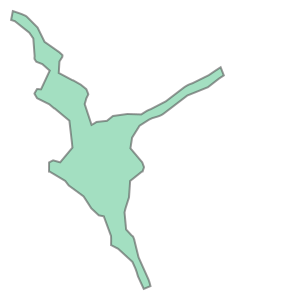

In [9]:
circles[0]

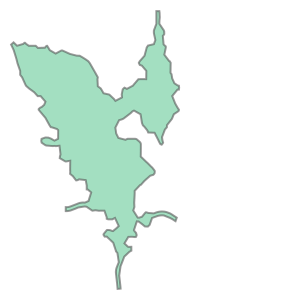

In [10]:
circles[1]

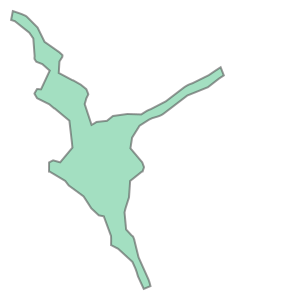

In [11]:
shells[0]

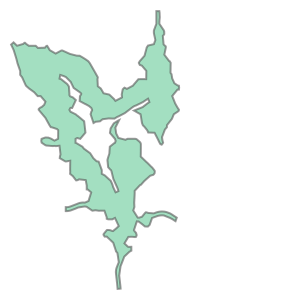

In [12]:
shells[1]

In [13]:
# make radii, open population shapefile
with fiona.open(population_fn) as col:
    info = [(shape(feat['geometry']), feat['properties']['POP20']) for feat in col]


In [14]:
population = [np.nan]
cumulative_population = [0]
avg_population_density = [np.nan]
shell_population_density =[np.nan]
total_area = [0]
shell_area = [0]
# circles = [None] + circles
# shells = [None] + shells

for i in range(len(shells)):
# for i, r in enumerate(rs[1:]):

    # buffer point
    # buffered = center.buffer(r)
    buffered = circles[i]
    shell = shells[i]
    
    # # construct the shell between the two radii
    # if i>0:
    #     shell = buffered.difference(circles[-1])
    # else:
    #     shell = buffered
    
    # # store geometry
    # circles.append(buffered)
    # shells.append(shell)
    
    # store areas
    total_area.append(buffered.area)
    shell_area.append(shell.area)
    
    # determine population in this shell
    pop = 0
    for shp, shp_pop in info:
        if intersects(shell, shp):      
            fraction = shell.intersection(shp).area/shp.area     
            pop += fraction*shp_pop
    
    # store populations
    population.append(pop)
    cumulative_population.append(cumulative_population[-1]+pop)
    
    # calculate population density
    avg_population_density.append(cumulative_population[-1]/total_area[-1])
    shell_population_density.append(pop/shell.area)
    
    print(f'SHELL {i}, cumulative pop: {cumulative_population[-1]}')

SHELL 0, cumulative pop: 32017.31662855698
SHELL 1, cumulative pop: 295184.7833941078
SHELL 2, cumulative pop: 891715.0615780839
SHELL 3, cumulative pop: 1648225.1845692869
SHELL 4, cumulative pop: 2048772.884156228
SHELL 5, cumulative pop: 2297655.685676438
SHELL 6, cumulative pop: 2646722.175811999
SHELL 7, cumulative pop: 2915153.5082080495
SHELL 8, cumulative pop: 3137168.1446074084
SHELL 9, cumulative pop: 3454972.082047916


In [15]:
len(avg_population_density)

11

## Plots

In [16]:
rs = np.linspace(0, 360.*10, num=11)
rs

array([   0.,  360.,  720., 1080., 1440., 1800., 2160., 2520., 2880.,
       3240., 3600.])

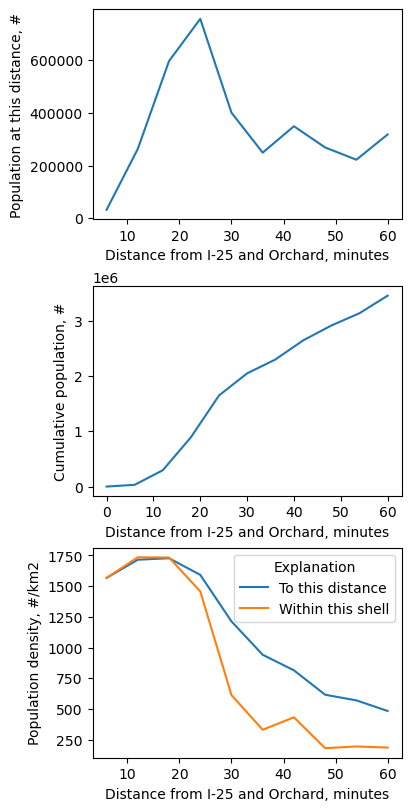

In [18]:
fig, axes = plt.subplots(figsize=(4,8),ncols=1, nrows=3, dpi=100, layout='constrained')

axes[0].plot(rs/60, population)
axes[0].set_xlabel("Distance from I-25 and Orchard, minutes")
axes[0].set_ylabel("Population at this distance, #")

axes[1].plot(rs/60, cumulative_population)
axes[1].set_xlabel("Distance from I-25 and Orchard, minutes")
axes[1].set_ylabel("Cumulative population, #")

axes[2].plot(rs/60, np.array(avg_population_density)*1e6, label ='To this distance')
axes[2].plot(rs/60, np.array(shell_population_density)*1e6, label="Within this shell")
axes[2].legend(title='Explanation')
axes[2].set_xlabel("Distance from I-25 and Orchard, minutes")
axes[2].set_ylabel("Population density, #/km2")
fig.savefig("summary.png", dpi=300)

## Export

In [19]:
with fiona.open(population_fn) as src:
    driver = src.driver
    crs = src.crs
    
schema = {'geometry': 'Polygon',
 'properties': {'pop': 'float',
                'density': 'float',
}}
# shell density
with fiona.open(f"shells_60min_{p1[0]}.shp", "w", 
                driver=driver, crs=crs, 
                schema=schema) as dst:

    for i in range(len(shells)):
        feat = {'geometry':mapping(shells[i]),
                'properties':{'pop':population[i+1],
                            'density': shell_population_density[i+1]*1e6}}

        dst.write(feat)
        
# selected tracts, write out density
selection = center.buffer(75000)   
with fiona.open(f"tract_density_60min_{p1[0]}.shp", "w", 
                driver=driver, crs=crs, 
                schema=schema) as dst:

    for shp, shp_pop in info:
        if intersects(selection,shp):
            feat = {'geometry':mapping(shp),
                'properties':{'pop':shp_pop,
                            'density': shp_pop/shp.area*1e6}}
            dst.write(feat) 
            